In [1]:
#importing necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data

### 1) Histogram Equalization

In [2]:
def get_histogram(img, L = 256):
    #helper code to get histogram of a particular image with intensity values ranging from 0 to L-1
    hist = [0]*L
    M,N = img.shape
    for i in range(M):
        for j in range(N):
            value = img[i,j]
            hist[value] = hist[value] + 1
            
    return hist

def get_cum_hist(hist,L = 256):
    #helper code to get the cumulative histogram values for a given histogram
    cum_hist = [0]*L
    for i in range(L):
        if i==0:
            cum_hist[i] = hist[i]
        else:
            cum_hist[i] = cum_hist[i-1] + hist[i]
            
    return np.array(cum_hist)

def get_pks(cum_hist, M, N):
    #helper code to return the probability of each intensity value
    return (cum_hist/(M*N))

def get_sks(pks, L = 256):
    #helper code to return the new histogram intensity map for the old intensity values
    sks = [0]*L
    for i in range(L):
        sks[i] = round((L-1) * pks[i])
    
    sks = np.array(sks, dtype = np.uint8)
    return sks



In [5]:
def plot_intensity_transformation(rks, sks):
    #helper code to plot the intensity transformation with old intensity value in x-axis and new intensity value at y-axis
    plt.plot(rks, sks)
    plt.xlabel("Original Intensity")
    plt.ylabel("Transformed Intensity")
    plt.title("Intensity transformation plot")
    plt.show()

In [6]:
def equalize_histogram(img, L = 256, plot_intensity_transform = True):
    #helper code to eqeualize histogram for a given image as input.
    M,N = img.shape
    hist = get_histogram(img, L)
    cum_hist = get_cum_hist(hist, L)
    pks = get_pks(cum_hist, M, N)
    sks = get_sks(pks, L)
    
    if plot_intensity_transform:
        plot_intensity_transformation(np.arange(L), sks)
    
    img_hist_equalized = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            rk = img[i,j]
            sk = sks[rk]
            img_hist_equalized[i,j] = sk
            
    return img_hist_equalized

**'HawkesBay' image**

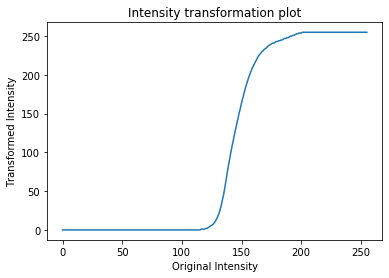

In [7]:
img = cv2.imread('HawkesBay.jpg',0)
img_equalized = equalize_histogram(img)

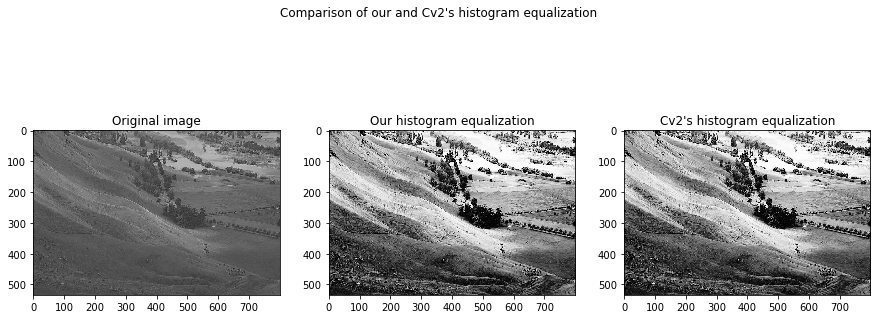

In [8]:
fig, axs = plt.subplots(1,3, figsize = (15,6))
axs[0].imshow(img, cmap = 'gray')
axs[0].set_title("Original image")

axs[1].imshow(img_equalized, cmap = 'gray')
axs[1].set_title("Our histogram equalization")

axs[2].imshow(cv2.equalizeHist(img), cmap = 'gray')
axs[2].set_title("Cv2's histogram equalization")

plt.suptitle("Comparison of our and Cv2's histogram equalization")
plt.show()

**Chest X-ray image**

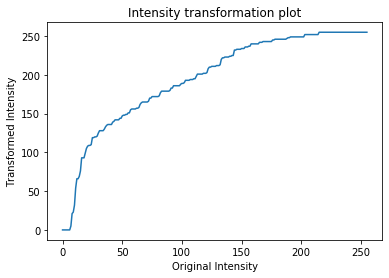

In [9]:
img = cv2.imread('chestxray1.png',0)
img_equalized = equalize_histogram(img)

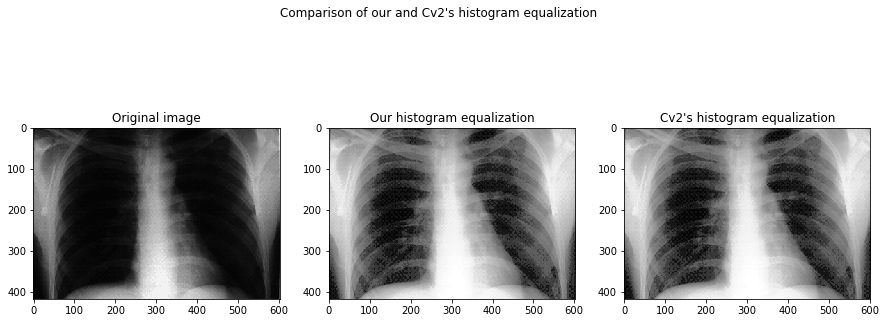

In [10]:
fig, axs = plt.subplots(1,3, figsize = (15,6))
axs[0].imshow(img, cmap = 'gray')
axs[0].set_title("Original image")

axs[1].imshow(img_equalized, cmap = 'gray')
axs[1].set_title("Our histogram equalization")

axs[2].imshow(cv2.equalizeHist(img), cmap = 'gray')
axs[2].set_title("Cv2's histogram equalization")

plt.suptitle("Comparison of our and Cv2's histogram equalization")
plt.show()

### Histogram matching code

Here, I have written the code for histogram matching and to test it, I used the example given in class and checked if the answer matched with the one from class. After successful verification, I moved on to question 2 in the next section.

In [11]:
def get_match_map(sks, Gzks, L = 256):
    #helper code to get the intensity mapping from rk to zk given the histogram equalized sks and Gzks as inputs
    match_map = [0] * L
    
    G_inv_map = {}
    for i in range(L):
        zk = i
        Gzk = Gzks[i]
        #since we are going linearly from lower values of zk to higher values, the inverse will always store the 
        #lowest value as the if condition will not be satisfied for higher zk values having same Gzk value
        if Gzk not in G_inv_map:
            G_inv_map[Gzk] = zk
        
    #setting map of all inverse values which are not present in Gzk as the next available Gzk inverse
    for i in range(L):
        if i not in G_inv_map:
            j = i+1
            while j not in G_inv_map:
                j = j + 1
            
            G_inv_map[i] = G_inv_map[j]
            
    #getting map from rk to zk
    for i in range(L):
        sk = sks[i]
        match_map[i] = G_inv_map[sk]
        
    return match_map
    

In [12]:
def hist_matching(hist1, hist2, M1 = 8, M2 = 8, N1 = 8, N2 = 8, L = 8):
    #helper code to find the histogram matching between two histograms 
    cum_hist1 = get_cum_hist(hist1, L)
    pks1 = get_pks(cum_hist1,  M1, N1)
    sks1 = get_sks(pks1, L)
    
    cum_hist2 = get_cum_hist(hist2, L)
    pks2 = get_pks(cum_hist2, M2, N2)
    Gzks = get_sks(pks2, L)
    
    match_map = get_match_map(sks1, Gzks, L)
    
    return match_map

In [13]:
hist1 = [8,10,10, 2, 12, 16, 4, 2]
hist2 = [0,0,0,0, 20, 20, 16, 8]

hist_matching(hist1, hist2)

[4, 4, 5, 5, 6, 6, 7, 7]

In [14]:
def histogram_specification(img, hist_map, M, N):
    #helper code to apply histogram matching to a given image with the histogram matching map as input 
    new_img = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            rk = img[i,j]
            zk = hist_map[rk]
            new_img[i,j] = zk
            
    return new_img

## 2) Histogram matching for 'image1' and 'image2'

In [15]:
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')

print (img1.shape, img2.shape)

(401, 600, 3) (479, 600, 3)


**a) Histogram of each channel for the two images**

In [16]:
#extracting channels from images

b1 = img1[:,:,0]
g1 = img1[:,:,1]
r1 = img1[:,:,2]

b2 = img2[:,:,0]
g2 = img2[:,:,1]
r2 = img2[:,:,2]


In [17]:
#getting histogram of each channel
hist_blue1 = get_histogram(b1)
hist_blue2 = get_histogram(b2)

hist_green1 = get_histogram(g1)
hist_green2 = get_histogram(g2)

hist_red1 = get_histogram(r1)
hist_red2 = get_histogram(r2)

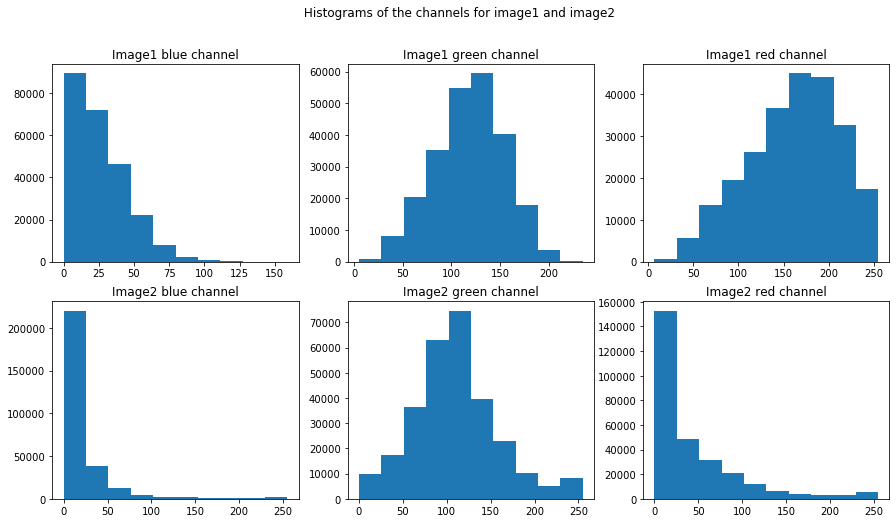

In [18]:
#plotting histogram of each channels
fig, axs = plt.subplots(2, 3, figsize = (15, 8))
axs[0,0].hist(b1.ravel())
axs[0,0].set_title("Image1 blue channel")

axs[1,0].hist(b2.ravel())
axs[1,0].set_title("Image2 blue channel")

axs[0,1].hist(g1.ravel())
axs[0,1].set_title("Image1 green channel")

axs[1,1].hist(g2.ravel())
axs[1,1].set_title("Image2 green channel")

axs[0,2].hist(r1.ravel())
axs[0,2].set_title("Image1 red channel")

axs[1,2].hist(r2.ravel())
axs[1,2].set_title("Image2 red channel")

plt.suptitle(" Histograms of the channels for image1 and image2")
plt.show()

**b) Matching each channel of image1 to corresponding channel of image2**

In [19]:
M1, N1 = b1.shape
M2, N2 = b2.shape

#histogram matching of blue channels of image 1 and image2
map_blue = hist_matching(hist_blue1, hist_blue2, M1, M2, N1, N2, L = 256)
#histogram matching of green channels of image 1 and image2
map_green = hist_matching(hist_green1, hist_green2, M1, M2, N1, N2, L = 256)
#histogram matching of red channels of image 1 and image2
map_red = hist_matching(hist_red1, hist_red2, M1, M2, N1, N2, L = 256)

In [20]:
#histogram specification of blue channel
blue_new = histogram_specification(b1, map_blue, M1, N1)
#histogram specification of green channel
green_new = histogram_specification(g1, map_green, M1, N1)
#histogram specification of red channel
red_new = histogram_specification(r1, map_red, M1, N1)


**c) Reconstruct the image1 in color**

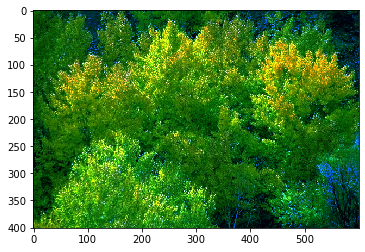

In [21]:
#recombining histogram specification of three channels
reconstructed_img = cv2.merge((blue_new, green_new, red_new))
reconstructed_img = reconstructed_img.astype('uint8')
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.show()

**d) Comparing result with original images**

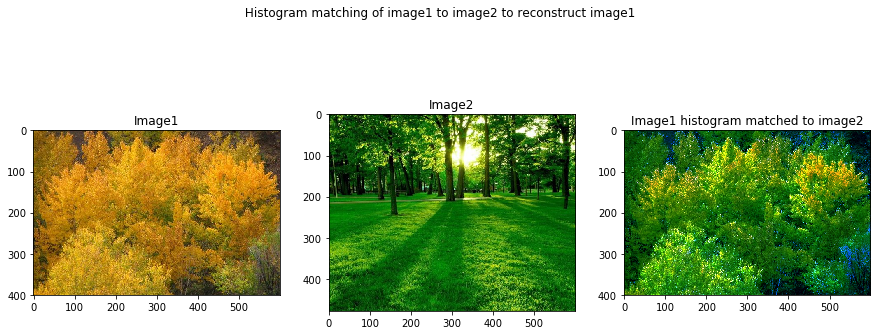

In [22]:
#comparison of results
fig, axs = plt.subplots(1,3,figsize= (15, 6))

axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0].set_title("Image1")

axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[1].set_title("Image2")

axs[2].imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
axs[2].set_title("Image1 histogram matched to image2")

plt.suptitle(" Histogram matching of image1 to image2 to reconstruct image1")
plt.show()

### 3) Crayons image

**a) Histogram equalization to 3 channels (R,G and B) and recombining them**

In [23]:
#reading crayons image
img = cv2.imread('crayons.jpg')
img.shape

(472, 592, 3)

In [24]:
#extracting channels from image
b = img[:,:,0]
g = img[:,:,1]
r = img[:,:,2]

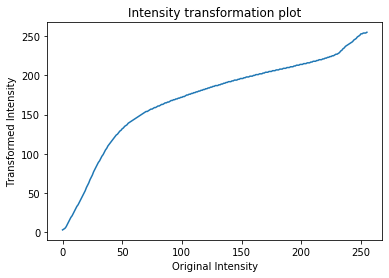

In [25]:
#histogram equalization to blue channel
b_he = equalize_histogram(b)

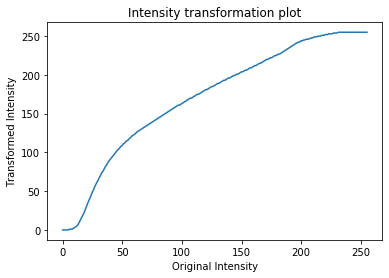

In [26]:
#histogram equalization of green channel
g_he = equalize_histogram(g)

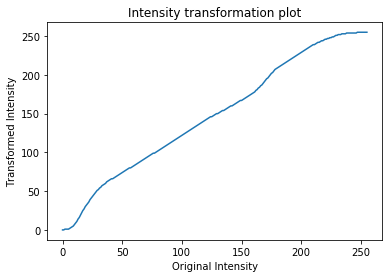

In [27]:
#histogram equalization of red channel
r_he = equalize_histogram(r)

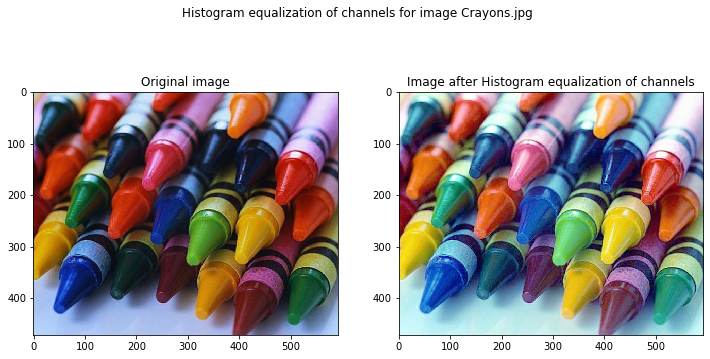

In [28]:
#recombining histogram equalized color channels and plotting
recombined = cv2.merge((b_he, g_he, r_he))
recombined = recombined.astype('uint8')

fig, axs = plt.subplots(1,2,figsize = (12,6))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original image")
axs[1].imshow(cv2.cvtColor(recombined, cv2.COLOR_BGR2RGB))
axs[1].set_title("Image after Histogram equalization of channels")

plt.suptitle("Histogram equalization of channels for image Crayons.jpg")
plt.show()

**b) Converting image to HSV , apply Histogram equalization to V channel and recombine**

In [29]:
#reading image and converting HSV color space
img = cv2.imread('crayons.jpg')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [30]:
img_hsv.shape

(472, 592, 3)

In [31]:
#slicing image into H, S, V channels
H = img_hsv[:,:,0]
S = img_hsv[:,:,1]
V = img_hsv[:,:,2]

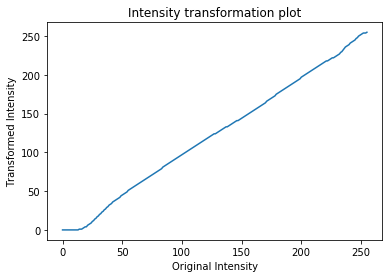

In [32]:
#histogram equalization of Value channel
V_he = equalize_histogram(V)
V_he= V_he.astype('uint8')

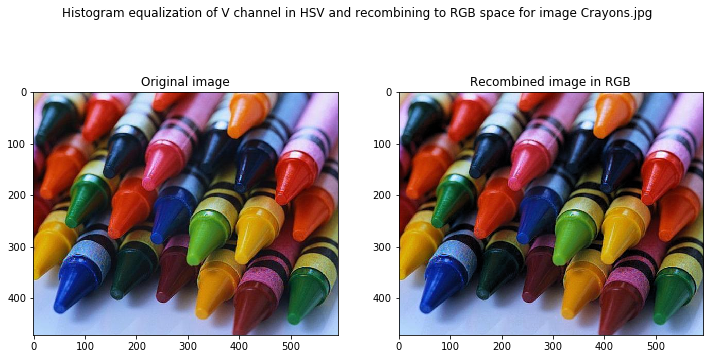

In [33]:
#recombining h,s, histogram equalized value channel to form image
recombined = cv2.merge((H,S, V_he))
recombined_rgb = cv2.cvtColor(recombined, cv2.COLOR_HSV2RGB)

fig, axs = plt.subplots(1,2,figsize = (12,6))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original image")
axs[1].imshow(recombined_rgb)
axs[1].set_title("Recombined image in RGB")

plt.suptitle("Histogram equalization of V channel in HSV and recombining to RGB space for image Crayons.jpg")
plt.show()

c) The image obtained this way(b) is far more clearer than the one obtained in (a). The reason is that HSV represents the color image in three channels (hue, saturation and value) and we are only applying histogram equalization to the value channel which represents the intensity/brightness. The hue and saturation components are kept as it is. This leads to a better contrast of the crayons whereas when we performed histogram equalization on all the three channels of the BGR image, the overall intensity of the image became similar for all the three channels which made it harder for it to distinguish the crayons. Below are the histogram plots for each channels of B,G, R and the H,S V channels respectively after the transformations. We can clearly see that the histograms are very similar for R,G and B channels. So after recombining them, the image contrast gets worse. However, for HSV, as we are only applying histogram equalization on value channel, this does not happen.

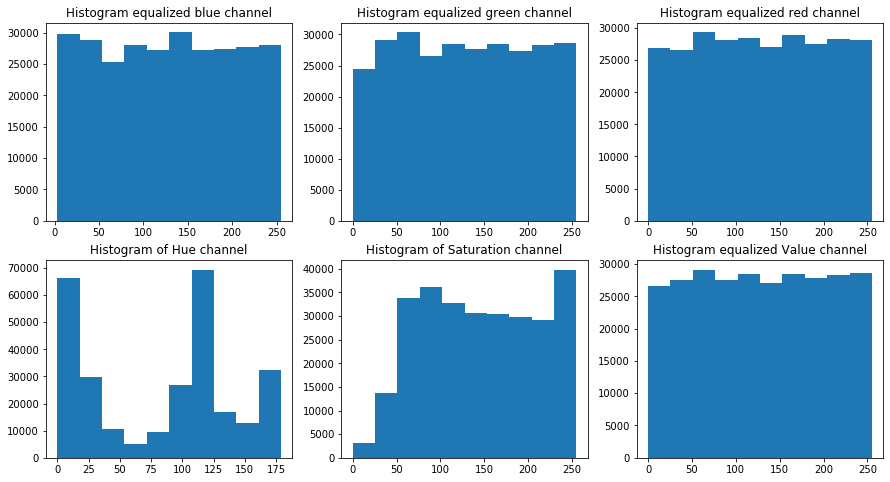

In [32]:
fig,axs = plt.subplots(2,3,figsize = (15,8))

axs[0,0].hist(b_he.ravel())
axs[0,0].set_title("Histogram equalized blue channel")

axs[0,1].hist(g_he.ravel())
axs[0,1].set_title("Histogram equalized green channel")

axs[0,2].hist(r_he.ravel())
axs[0,2].set_title("Histogram equalized red channel")


axs[1,0].hist(H.ravel())
axs[1,0].set_title("Histogram of Hue channel")

axs[1,1].hist(S.ravel())
axs[1,1].set_title("Histogram of Saturation channel")

axs[1,2].hist(V_he.ravel())
axs[1,2].set_title("Histogram equalized Value channel")

plt.show()

### 4) Adaptive Histogram Equalization

In [34]:
#reading grayscale image "camera" from skimage data repository
img = data.camera()
img.shape

(512, 512)

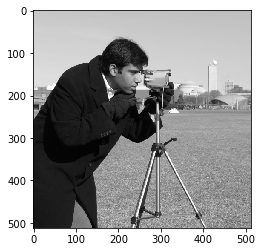

In [35]:
plt.imshow(img, cmap ='gray')
plt.show()

In [43]:
#taking the value of k as input where we slide over the window of size k*k
k = int(input("Enter value of k for window size k*k:"))
M,N = img.shape


Enter value of k for window size k*k:11


In [44]:
def adaptive_histogram_equalization(img, k, M, N, stride):
    #helper function for SWAHE
    offset_x = 0
    c = 0
    img_ahe = img.copy()
    while (offset_x + k)<=M:
        offset_y = 0
        while (offset_y + k) <= N:
            nbd = img_ahe[offset_x:offset_x + k, offset_y: offset_y + k]
            
            #nbd_he = equalize_histogram(nbd, plot_intensity_transform = False)
            nbd_he = cv2.equalizeHist(nbd)
            img_ahe[offset_x:offset_x+k, offset_y:offset_y+k] = nbd_he
            
            offset_y +=stride
            c+=1
        offset_x +=stride
    #print (c)
    return img_ahe

In [45]:
img_ahe = adaptive_histogram_equalization(img, k, M, N, stride = 1)

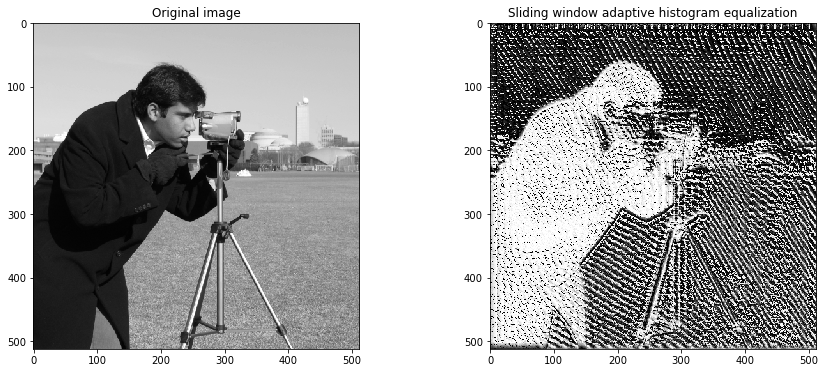

In [46]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original image")


axs[1].imshow(img_ahe, cmap='gray')
axs[1].set_title("Sliding window adaptive histogram equalization")

plt.show()

**c) Local Histogram Equalization from blocks and combining them together** 

In [60]:
M,N = img.shape
block_size = 48
block_M = int(M/block_size)
block_N = int(N/block_size)

In [61]:
block_number = 0
blocked_img_he = np.zeros((M,N))

for i in range(0,M,block_size):
    for j in range(0, N, block_size):
        block = img[i:(i+block_size),j:(j+block_size)].copy()
        #block_he = equalize_histogram(block, plot_intensity_transform = False)
        block_he = cv2.equalizeHist(block)
        blocked_img_he[i:(i+block_size), j:(j+block_size)] = block_he
        block_number+=1
        


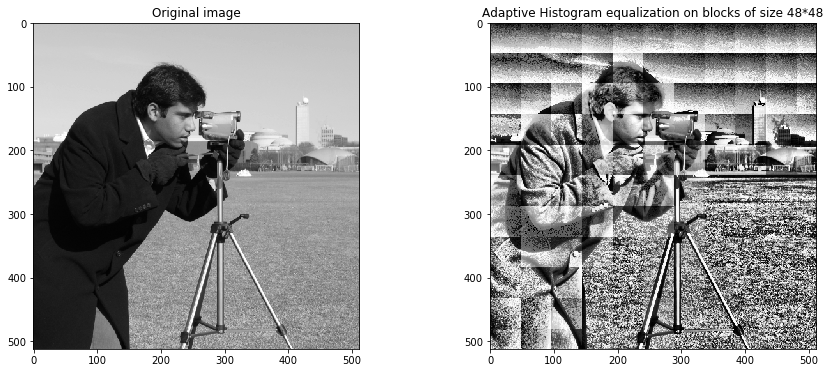

In [62]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original image")


axs[1].imshow(blocked_img_he, cmap='gray')
axs[1].set_title("Adaptive Histogram equalization on blocks of size {}*{}".format(block_size,block_size))

plt.show()

**d) CLAHE**

In [63]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img_2 = clahe.apply(img)

In [65]:
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
clahe_img_1 = clahe.apply(img)


In [66]:
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
clahe_img_pt5 = clahe.apply(img)

In [67]:
clahe = cv2.createCLAHE(clipLimit=0, tileGridSize=(8,8))
clahe_img_0 = clahe.apply(img)

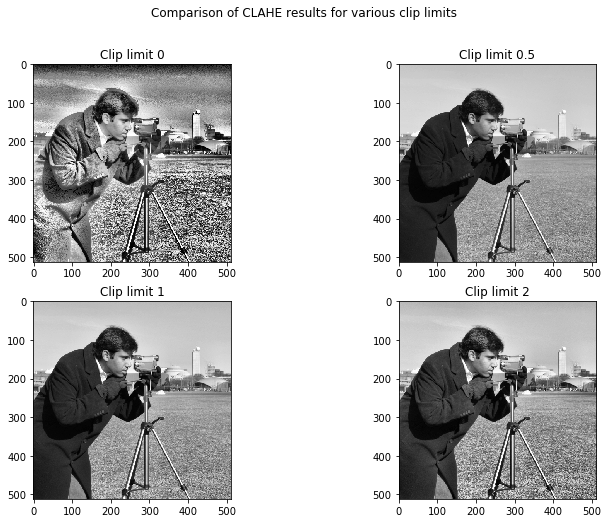

In [69]:
fig, axs = plt.subplots(2,2, figsize = (12,8))

axs[0,0].imshow(clahe_img_0,cmap = 'gray')
axs[0,0].set_title("Clip limit 0")

axs[0,1].imshow(clahe_img_pt5, cmap = 'gray')
axs[0,1].set_title("Clip limit 0.5")

axs[1,0].imshow(clahe_img_1, cmap = 'gray')
axs[1,0].set_title("Clip limit 1")

axs[1,1].imshow(clahe_img_2, cmap = 'gray')
axs[1,1].set_title("Clip limit 2")

plt.suptitle("Comparison of CLAHE results for various clip limits")
plt.show()

**e) Comparison of results**

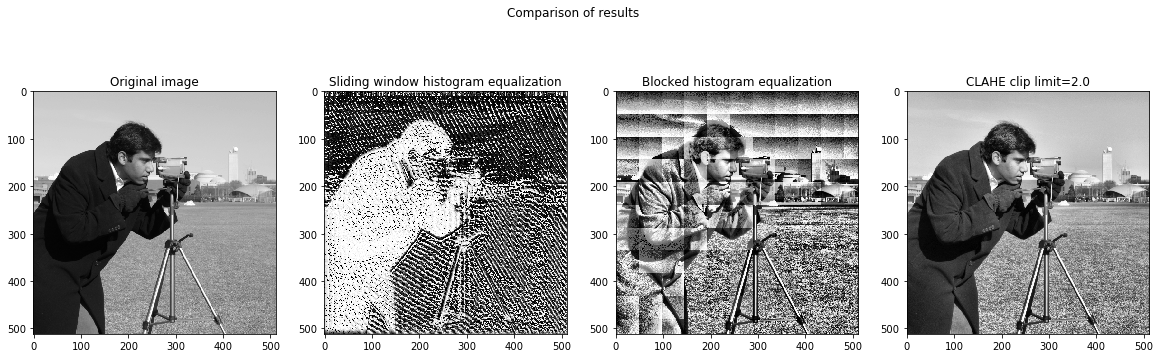

In [72]:
fig, axs= plt.subplots(1,4, figsize = (20,6))

axs[0].imshow(img, cmap = 'gray')
axs[0].set_title("Original image")

axs[1].imshow(img_ahe, cmap = 'gray')
axs[1].set_title("Sliding window histogram equalization")

axs[2].imshow(blocked_img_he, cmap = 'gray')
axs[2].set_title("Blocked histogram equalization")

axs[3].imshow(clahe_img_2, cmap = 'gray')
axs[3].set_title("CLAHE clip limit=2.0")

plt.suptitle("Comparison of results")
plt.show()

### 5) Intensity Slicing

From the histogram of the image cameraman, I am slicing intensities in the range 120-150. For intensity slicing without background any pixel with intensity not in this range is made to 0 and pixel with intensity in this range is made to 255. For intensity slicing with background pixels with intensity in this range is made to 255 whereas all other pixels are kept as it is. 

(array([35368., 38785.,  5713.,  4093.,  9626., 38530., 45402., 39344.,
        42553.,  2730.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

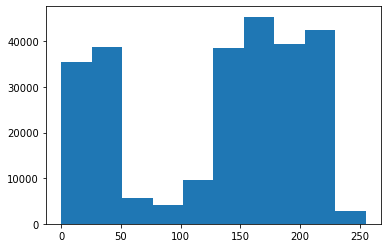

In [73]:
img = data.camera()
plt.hist(img.ravel())

In [15]:
M, N = img.shape
highlight_range = (120,150)
img_wo_bg = np.zeros((M,N))
img_with_bg = np.zeros((M,N))

for i in range(M):
    for j in range(N):
        if highlight_range[0]<=img[i,j]<=highlight_range[1]:
            img_wo_bg[i,j] = 255
            img_with_bg[i,j] = 255
        else:
            img_new[i,j] = 0 
            img_with_bg[i,j] = img[i,j]
            


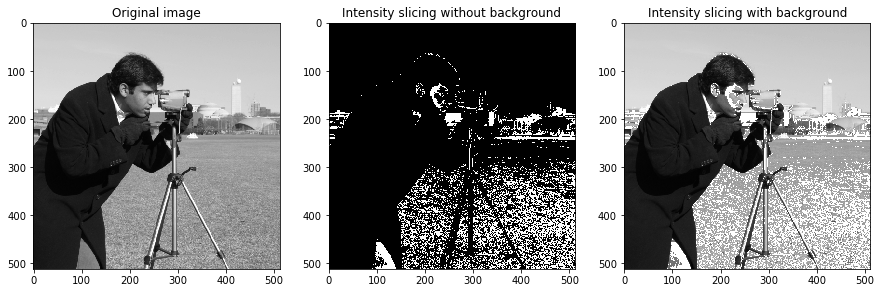

In [16]:
fig, axs = plt.subplots(1,3 , figsize = (15,6))

axs[0].imshow(img,cmap = 'gray')
axs[0].set_title("Original image")

axs[1].imshow(img_wo_bg, cmap = 'gray')
axs[1].set_title("Intensity slicing without background")

axs[2].imshow(img_with_bg, cmap = 'gray')
axs[2].set_title("Intensity slicing with background")

plt.show()

### 6) Bit-plane slicing

In [18]:
img = data.camera()
M,N = img.shape

In [27]:
temp = []
for i in range(M):
    for j in range(N):
        b = np.binary_repr(img[i,j], 8) #binary representation of intensity
        temp.append(b)

#storing bit planes 
bit_planes = []
for i in range(1,9):
    t = []
    for bin_repr in temp:
        t.append(int(bin_repr[-i]))
        
    t = np.array(t).reshape((M,N))
    t = t*(2**(i-1))
    t = t.astype(np.uint8)
    
    bit_planes.append(t)
    


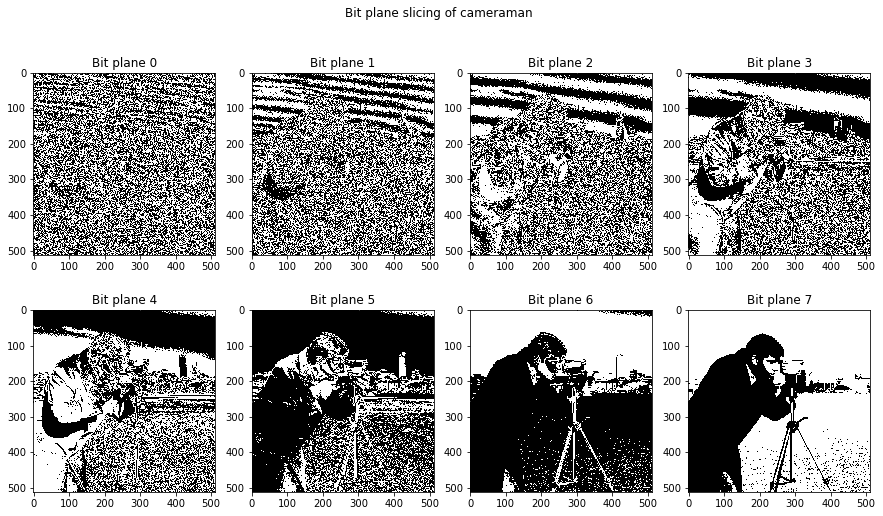

In [28]:
fig, axs = plt.subplots(2,4, figsize = (15,8))

for i in range(2):
    for j in range(4):
        c = (i*4) + j
        axs[i,j].imshow(bit_planes[c],cmap = 'gray')
        axs[i,j].set_title("Bit plane %d" %c)
        
plt.suptitle("Bit plane slicing of cameraman")
plt.show()

Combining bit planes 7 and 6 to reconstruct the image

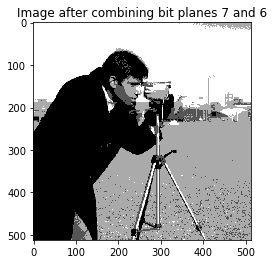

In [31]:
new_img = bit_planes[7] + bit_planes[6]
plt.imshow(new_img, cmap = 'gray')
plt.title("Image after combining bit planes 7 and 6")
plt.show()

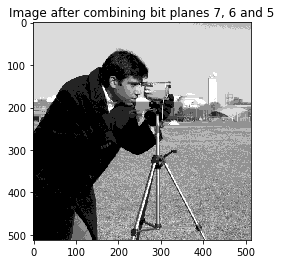

In [32]:
new_img = bit_planes[7] + bit_planes[6] + bit_planes[5]
plt.imshow(new_img, cmap = 'gray')
plt.title("Image after combining bit planes 7, 6 and 5")
plt.show()

We can see that by combining bit planes 7,6 and 5 we can get an image which resembles the original image.